## Module 8 Boosting Trees Assignment 2:
## Using pandas and custom built Ada Boost
# Boosting a decision stump

The goal of this notebook is to implement your own boosting module.

* Use SFrames to do some feature engineering.
* Modify the decision trees to incorporate weights.
* Implement Adaboost ensembling.
* Use your implementation of Adaboost to train a boosted decision stump ensemble.
* Evaluate the effect of boosting (adding more decision stumps) on performance of the model.
* Explore the robustness of Adaboost to overfitting.

## Using  GraphLab Create

Make sure you have the latest version of GraphLab Create **(1.8.3 or newer)**. Upgrade by
```
   pip install graphlab-create --upgrade
```
See [this page](https://dato.com/download/) for detailed instructions on upgrading.

In [184]:
import sframe as sf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import division  #ensures floating point division

# Getting the data ready

**1.** We will be using the same [LendingClub](https://www.lendingclub.com/) dataset as in the previous assignment.

In [185]:
loans = sf.SFrame('../Week3/lending-club-data.gl/')

### Extracting the target and the feature columns

**2.** Repeat some of the feature processing steps that we saw in the previous assignment:

First, we re-assign the target to have +1 as a safe (good) loan, and -1 as a risky (bad) loan.

Next, we select four categorical features: 
1. grade of the loan 
2. the length of the loan term
3. the home ownership status: own, mortgage, rent
4. number of years of employment.

In [186]:
target = 'safe_loans'
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]

# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)

# just check if conversion done properly, before removing the 'bad_loans' col
print loans[features + ['bad_loans', 'safe_loans']].head(2)

# removing row traightforward
# to remove/drop a column, axis=1 denotes that we are referring to a column
# see http://chrisalbon.com/python/pandas_dropping_column_and_rows.html

loans = loans.remove_column('bad_loans')

loans = loans[features + [target]]  #can only concatenate list (not "str") to list
loans.head(2)

+-------+------------+----------------+------------+-----------+------------+
| grade |    term    | home_ownership | emp_length | bad_loans | safe_loans |
+-------+------------+----------------+------------+-----------+------------+
|   B   |  36 months |      RENT      | 10+ years  |     0     |     1      |
|   C   |  60 months |      RENT      |  < 1 year  |     1     |     -1     |
+-------+------------+----------------+------------+-----------+------------+
[2 rows x 6 columns]



grade,term,home_ownership,emp_length,safe_loans
B,36 months,RENT,10+ years,1
C,60 months,RENT,< 1 year,-1


If you are using SFrame, proceed to the section "Subsample dataset to make sure classes are balanced".

If you are NOT using SFrame, download the list of indices for the training and test sets: module-8-assignment-2-train-idx.json, module-8-assignment-2-test-idx.json. Then follow the following steps:

*    Apply one-hot encoding to loans. Your tool may have a function for one-hot encoding. Alternatively, see #7 for implementation hints.
*    Load the JSON files into the lists train_idx and test_idx.
*    Perform train/validation split using train_idx and test_idx. In Pandas, for instance:

### Subsample dataset to make sure classes are balanced

**3.** Just as we did in the previous assignment, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We use `seed=1` so everyone gets the same results.

In [187]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(percentage, seed=1)
loans_data = risky_loans_raw.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502236174422
Percentage of risky loans                : 0.497763825578
Total number of loans in our new dataset : 46508


**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

### Transform categorical data into binary features

**4.** In this assignment, we will work with **binary decision trees**. Since all of our features are currently categorical features, we want to turn them into binary features using 1-hot encoding. 

We can do so with the following code block (see the first assignments for more details):

In [188]:
for feature in features:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})    
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)
    
    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

Let's see what the feature columns look like now:

In [189]:
features = loans_data.column_names()
features.remove('safe_loans')  # Remove the response variable from features list
features

['grade.A',
 'grade.B',
 'grade.C',
 'grade.D',
 'grade.E',
 'grade.F',
 'grade.G',
 'term. 36 months',
 'term. 60 months',
 'home_ownership.MORTGAGE',
 'home_ownership.OTHER',
 'home_ownership.OWN',
 'home_ownership.RENT',
 'emp_length.1 year',
 'emp_length.10+ years',
 'emp_length.2 years',
 'emp_length.3 years',
 'emp_length.4 years',
 'emp_length.5 years',
 'emp_length.6 years',
 'emp_length.7 years',
 'emp_length.8 years',
 'emp_length.9 years',
 'emp_length.< 1 year',
 'emp_length.n/a']

**5.** This technique of turning categorical variables into binary variables is called one-hot encoding. Using the software of your choice, perform one-hot encoding on the four features described above. You should now have 25 binary features.

We will use this sframe coding. Pandas has a get_dummies() equivalent but since it doesn't prepend the newly created feature levels (such as for grade, A, B, C ,D,,,) with name of categorical feature (like grade.A, grade.B...) we get name conflicts if during encoding, 2 categorical variables spit out same names for encoded levels, A, B etc

### Train-test split

**6.** We split the data into training and test sets with 80% of the data in the training set and 20% of the data in the test set. We use `seed=1` so that everyone gets the same result.

In [190]:
train_data, test_data = loans_data.random_split(0.8, seed=1)
# we convert both train and validation sframes to dataframes
train_data = train_data.to_dataframe()
test_data= test_data.to_dataframe()

# Weighted decision trees

**7.** Let's modify our decision tree code from Module 5 to support weighting of individual data points.

### Weighted error definition

**8.** Consider a model with $N$ data points with:
* Predictions $\hat{y}_1 ... \hat{y}_n$ 
* Target $y_1 ... y_n$ 
* Data point weights $\alpha_1 ... \alpha_n$.

Then the **weighted error** is defined by:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i}
$$
where $1[y_i \neq \hat{y_i}]$ is an indicator function that is set to $1$ if $y_i \neq \hat{y_i}$.


### Write a function to compute weight of mistakes

**9.** Write a function that calculates the weight of mistakes for making the "weighted-majority" predictions for a dataset. The function accepts two inputs:
* `labels_in_node`: Targets $y_1 ... y_n$ 
* `data_weights`: Data point weights $\alpha_1 ... \alpha_n$

We are interested in computing the (total) weight of mistakes, i.e.
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}].
$$
This quantity is analogous to the number of mistakes, except that each mistake now carries different weight. It is related to the weighted error in the following way:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}
$$

The function **intermediate_node_weighted_mistakes** should first compute two weights: 
 * $\mathrm{WM}_{-1}$: weight of mistakes when all predictions are $\hat{y}_i = -1$ i.e $\mathrm{WM}(\mathbf{\alpha}, \mathbf{-1}$)
 * $\mathrm{WM}_{+1}$: weight of mistakes when all predictions are $\hat{y}_i = +1$ i.e $\mbox{WM}(\mathbf{\alpha}, \mathbf{+1}$)
 
 where $\mathbf{-1}$ and $\mathbf{+1}$ are vectors where all values are -1 and +1 respectively.
 
After computing $\mathrm{WM}_{-1}$ and $\mathrm{WM}_{+1}$, the function **intermediate_node_weighted_mistakes** should return the lower of the two weights of mistakes, along with the class associated with that weight. We have provided a skeleton for you with `YOUR CODE HERE` to be filled in several places.

In [191]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    # NB B4 we just counted how many +1 labels, now we add weights of all +1's
    # safe_loans_count = sum(labels_in_node == +1)
    print "total_weight_positive", total_weight_positive
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    # so if our classifier, classifies all data points as -1 class,
    # weight of mistakes would be sum of weights of the OTHER (+1) class
    weighted_mistakes_all_negative_pred = total_weight_positive
    print "weight of mistakes when all predictions are ŷi=−1 = ", total_weight_positive
    
    
    # Sum the weights of all entries with label -1
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    # NB B4 we just counted how many -1 labels, now we add weights of all -1's
    # risky_loans_count = sum(labels_in_node == -1)    
    print "total_weight_negative", total_weight_negative
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    # weight of mistakes would be sum of weights of the OTHER (-1) class
    weighted_mistakes_all_positive_pred = total_weight_negative
    print "weight of mistakes when all predictions are ŷi=+1 = ", total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    if (weighted_mistakes_all_negative_pred < weighted_mistakes_all_positive_pred):
        return (weighted_mistakes_all_negative_pred, -1)
    else:
        return (weighted_mistakes_all_positive_pred, +1)

**Checkpoint:** Test your **intermediate_node_weighted_mistakes** function, run the following cell:
Here we have 2 labels -1 and 3 labels +1. Majority is +1, so num mistakes wud be 2 (num of -1 labels). Note here we not counting num of data points we make mistakes with but the weight of those data points, so things are a bit different. The sum of weights of the 2 labels (-1) is not 2 but 1+2 = 3). The combined weight of the 3 +ve +1 labels is 0.5+1+1 = 2.5. Now we have to check for which label prediction the weight of mistakes/misclassified class is lowest. If we predict all data points to be -1 class, then the wt of mistakes would be 2.5 (wt of the +1 class). If we predict all data points as +1 class, then weight of mistakes is weight of the miclassified class i.e the +1 class i.e 3. 2.5 is < 3, so if we predict all data points as -1 class, we get lowest weight of misclassified class. So we return 2.5 as the min of the 2 misclassified classes(min[2.5,3]) and the class prediction that achieves lowest mistakes would be when we predict all points in intermediate node to be -1 class.

In [192]:
example_labels = pd.Series([-1, -1, 1, 1, 1])
example_data_weights = pd.Series([1., 2., .5, 1., 1.])
if intermediate_node_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print 'Test passed!'
else:
    print 'Test failed... try again!'

total_weight_positive 2.5
weight of mistakes when all predictions are ŷi=−1 =  2.5
total_weight_negative 3.0
weight of mistakes when all predictions are ŷi=+1 =  3.0
Test passed!


**10.** Recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

**Quiz Question:** If we set the weights $\mathbf{\alpha} = 1$ for all data points, how is the weight of mistakes $\mbox{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ related to the `classification error`?  

weight of mistakes $\mbox{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ = classification error X sum weights all data points

### Function to pick best feature to split on

**11.** We continue modifying our decision tree code from the earlier assignment to incorporate weighting of individual data points. The next step is to pick the best feature to split on.

The **best_splitting_feature** function is similar to the one from the earlier assignment with two minor modifications:
  1. The function **best_splitting_feature** should now accept an extra parameter `data_weights` to take account of weights of data points.
  2. Instead of computing the number of mistakes in the left and right side of the split, we compute the weight of mistakes for both sides, add up the two weights, and divide it by the total weight of the data.
  
Complete the following function. Comments starting with `DIFFERENT HERE` mark the sections where the weighted version differs from the original implementation.

In [193]:
def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        print "\n************Trying out feature:", feature
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split =  data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the SAME FILTERING to data_weights to create left_data_weights, right_data_weights
        ## YOUR CODE HERE
        left_data_weights =  data_weights[ data[feature] == 0]
        right_data_weights = data_weights[ data[feature] == 1]
        
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], 
                                                                                 left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], 
                                                                                   right_data_weights)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        ## YOUR CODE HERE
        error = (left_weighted_mistakes + right_weighted_mistakes)/sum(data_weights)
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            #print "\nFOUND LOWER ERROR using %s, error is %0.4f, previous best error %0.4f" \
            #                                 %(feature, error, best_error)
            best_feature = feature
            best_error = error
    
    print "\nBEST FEATURE TO SPLIT ON THAT PRODUCES LOWEST ERROR RATE: %s, error rate: %0.4f" \
                                             %(best_feature, best_error)
    
    # Return the best feature we found
    return best_feature

**Checkpoint:** Now, we have another checkpoint to make sure you are on the right track.

In [194]:
example_data_weights = pd.Series(len(train_data)* [1.5])
if best_splitting_feature(train_data, features, target, example_data_weights) == 'term. 36 months':
    print 'Test passed!'
else:
    print 'Test failed... try again!'


************Trying out feature: grade.A
total_weight_positive 22314.0
weight of mistakes when all predictions are ŷi=−1 =  22314.0
total_weight_negative 25827.0
weight of mistakes when all predictions are ŷi=+1 =  25827.0
total_weight_positive 5808.0
weight of mistakes when all predictions are ŷi=−1 =  5808.0
total_weight_negative 1887.0
weight of mistakes when all predictions are ŷi=+1 =  1887.0

************Trying out feature: grade.B
total_weight_positive 19087.5
weight of mistakes when all predictions are ŷi=−1 =  19087.5
total_weight_negative 21199.5
weight of mistakes when all predictions are ŷi=+1 =  21199.5
total_weight_positive 9034.5
weight of mistakes when all predictions are ŷi=−1 =  9034.5
total_weight_negative 6514.5
weight of mistakes when all predictions are ŷi=+1 =  6514.5

************Trying out feature: grade.C
total_weight_positive 21375.0
weight of mistakes when all predictions are ŷi=−1 =  21375.0
total_weight_negative 20343.0
weight of mistakes when all

**Note**. If you get an exception in the line of "the logical filter has different size than the array", try upgradting your GraphLab Create installation to 1.8.3 or newer.

**Very Optional**. Relationship between weighted error and weight of mistakes

By definition, the weighted error is the weight of mistakes divided by the weight of all data points, so
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i} = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}.
$$

In the code above, we obtain $\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})$ from the two weights of mistakes from both sides, $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}})$ and $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})$. First, notice that the overall weight of mistakes $\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ can be broken into two weights of mistakes over either side of the split:
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})
= \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]
= \sum_{\mathrm{left}} \alpha_i \times 1[y_i \neq \hat{y_i}]
 + \sum_{\mathrm{right}} \alpha_i \times 1[y_i \neq \hat{y_i}]\\
= \mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})
$$
We then divide through by the total weight of all data points to obtain $\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})$:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})
= \frac{\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})}{\sum_{i=1}^{n} \alpha_i}
$$

### Building the tree

**12.** With the above functions implemented correctly, we are now ready to build our decision tree. Recall from the previous assignments that each node in the decision tree is represented as a dictionary which contains the following keys:

    { 
       'is_leaf'            : True/False.
       'prediction'         : Prediction at the leaf node.
       'left'               : (dictionary corresponding to the left tree).
       'right'              : (dictionary corresponding to the right tree).
       'features_remaining' : List of features that are posible splits.
    }
    
Let us start with a function that creates a leaf node given a set of target values:

In [195]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class
    
    return leaf 

**13.** We provide a function that learns a weighted decision tree recursively and implements 3 stopping conditions:
1. All data points in a node are from the same class.
2. No more features to split on.
3. Stop growing the tree when the tree depth reaches **max_depth**. 

In [196]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print "--------------------------------------------------------------------"
    print "Subtree, depth = %s (%s data points)." % (current_depth, len(target_values))
    
    # STOPPING CONDITION 1: All nodes are of the same type.
    # (Check if there are NO or ZERO mistakes at current node.
    # Note we don't check that mistakes exactly zero but ALMOST 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print "\n####------------CREATE LEAF-------------------####"
        print "Stopping condition 1 reached. No mistakes - PURE node!"
        print "Backtrack and process other split from parent node!\n\n"
        # If not mistakes at current node, make current node a leaf node
        return create_leaf(target_values, data_weights)
    
    # STOPPING CONDITION 2: No more features to split on.
    # (check if there are remaining features to consider splitting on)
    # if len(remaining_features) is  0 then no features left in list 
    if remaining_features == []:
        print "\n####------------CREATE LEAF-------------------####"
        print "Stopping condition 2 reached. No remaining splitting features."   
        print "Backtrack and process other split from parent node!\n\n"
        # If there are no remaining features to consider, make current node a leaf node
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    # EARLY STOPPING CONDITION 1: Reached max depth limit.
    if current_depth > max_depth:
        print "\n####------------CREATE LEAF-------------------####"
        print "Early stopping condition 1 reached. Reached maximum depth."
        print "Backtrack and process other split from parent node!\n\n"
        # If the max tree depth has been reached, make current node a leaf node
        return create_leaf(target_values, data_weights)

    
    # Note that create_leaf() makes another call intermediate_node_weighted_mistakes()
    # weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # to find majority class and assign prediction to leaf
    # so we see screen dumps for leaf node,num +ve/-ve etc repeats
    
    # EARLY STOPPING CONDITION 2: Reached the minimum node size.
    # If the number of data points is less than or equal to the minimum size, return a leaf.
    #if  reached_minimum_node_size(data, min_node_size):         ## YOUR CODE HERE 
    #    print "Early stopping condition 2 reached. Reached minimum node size."
    #    return create_leaf(target_values)  ## YOUR CODE HERE    


    # Find the best splitting feature (recall the function best_splitting_feature implemented above)
    # we assume that this fn will always find n return a feature - so no error checking
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    
    # Now that we are fully convinced that this split is worth it, 
    # remove feature so we don't try split on it again on this branch of the tree
    # and then build decision tree on the left and right branches    
    remaining_features.remove(splitting_feature)
    

    # Split on the best feature that we found.     
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    # grab the weights for data points in each of the esplits
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print "\n\nSPAWN NEW TREES split on feature: %s (Left = %s, Right = %s)" \
            % (splitting_feature, len(left_split), len(right_split) )
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print "\n####------------CREATE PURE LEFT LEAF NODE----####."
        print "Don't bother with right split.Backtrack and process parents parent!\n\n"
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print "\n####------------CREATE PURE RIGHT LEAF NODE----####."
        print "Don't bother with left split.Backtrack and process parents parent!\n\n"
        return create_leaf(right_split[target], data_weights)
    
    
    # Now enter recursive binary splitting -  a top-down, greedy approach
    # Start at top of the tree (point at which all observations belong to a single region) 
    # and then successively splits the predictor space; 
    # each split is indicated via two new branches further down on the tree    
    # remaining_features won't consider feature we split on above,
    # inc depth as we going one level deeper, target is just 'soft_loans'
    print "########### Growing left branch of tree further ##############"
    # Takes dataframe where value for predictor_feature (splitting_feature) is 0 and
    # subset of features and grows decision tree on that branch       
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)

    
    print "########### Growing right branch of tree further ##############"
    # Takes dataframe where value for predictor_feature (splitting_feature) is 1 and
    # subset of features and grows decision tree on that branch   
    
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

**14.**  Finally, write a recursive function to count the nodes in your tree:

In [197]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

Run the following test code to check your implementation. Make sure you get **'Test passed'** before proceeding.

In [198]:
#in the test, we set data_weights for all data points as 1.0, 
#so this would give us same result as previous assignment decision tree 
example_data_weights = pd.Series([1.0 for i in range(len(train_data))])
small_data_decision_tree = weighted_decision_tree_create(train_data, features, target,
                                        example_data_weights, max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print 'Test passed!'
else:
    print 'Test failed... try again!'
    print 'Number of nodes found:', count_nodes(small_data_decision_tree)
    print 'Number of nodes that should be there: 7' 

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
total_weight_positive 18748.0
weight of mistakes when all predictions are ŷi=−1 =  18748.0
total_weight_negative 18476.0
weight of mistakes when all predictions are ŷi=+1 =  18476.0

************Trying out feature: grade.A
total_weight_positive 14876.0
weight of mistakes when all predictions are ŷi=−1 =  14876.0
total_weight_negative 17218.0
weight of mistakes when all predictions are ŷi=+1 =  17218.0
total_weight_positive 3872.0
weight of mistakes when all predictions are ŷi=−1 =  3872.0
total_weight_negative 1258.0
weight of mistakes when all predictions are ŷi=+1 =  1258.0

************Trying out feature: grade.B
total_weight_positive 12725.0
weight of mistakes when all predictions are ŷi=−1 =  12725.0
total_weight_negative 14133.0
weight of mistakes when all predictions are ŷi=+1 =  14133.0
total_weight_positive 6023.0
weight of mistakes when all predictions are ŷi=

Let us take a quick look at what the trained tree is like. You should get something that looks like the following

```
{'is_leaf': False,
    'left': {'is_leaf': False,
        'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
        'prediction': None,
        'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
        'splitting_feature': 'grade.A'
     },
    'prediction': None,
    'right': {'is_leaf': False,
        'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
        'prediction': None,
        'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
        'splitting_feature': 'grade.D'
     },
     'splitting_feature': 'term. 36 months'
}```

In [199]:
small_data_decision_tree

{'is_leaf': False,
 'left': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'grade.A'},
 'prediction': None,
 'right': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'splitting_feature': 'grade.D'},
 'splitting_feature': 'term. 36 months'}

### Making predictions with a weighted decision tree

**15.**  To make a single prediction, we must start at the root and traverse down the decision tree in recursive fashion. This function classifies one data point. It can also return the probability if you want to play around with that as well.

In [200]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    
    if tree['is_leaf']:
        if annotate: 
            print "At leaf, predicting %s" % tree['prediction']
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]#.item()
        if annotate: 
            print "Split on %s = %s" % (tree['splitting_feature'], split_feature_value)
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

### Evaluating the tree

**16.** Create a function called *evaluate_classification_error* to evaluate a decision tree by computing the classification error of the tree on the given dataset.

Again, recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

The function called **evaluate_classification_error** takes in as input:
1. `tree` (as described above)
2. `data` (an SFrame)

The function does not change because of adding data point weights, so its same as that for decision tree where data points don't have weights.

Note that when using .apply() with pandas dataframe, [pandas.DataFrame.apply()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html), also need to supply axis info. See [also](http://chrisalbon.com/python/pandas_apply_operations_to_dataframes.html)

* axis : {0 or ‘index’, 1 or ‘columns’}, default 0
 *        0 or ‘index’: apply function to each column
 *        1 or ‘columns’: apply function to each row

In [201]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x), axis=1)
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [202]:
test_data.head(1)

,safe_loans,grade.A,grade.B,grade.C,grade.D,grade.E,grade.F,grade.G,term. 36 months,term. 60 months,...,emp_length.2 years,emp_length.3 years,emp_length.4 years,emp_length.5 years,emp_length.6 years,emp_length.7 years,emp_length.8 years,emp_length.9 years,emp_length.< 1 year,emp_length.n/a
0,-1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


In [203]:
evaluate_classification_error(small_data_decision_tree, test_data)

0.3981042654028436

### Example: Training a weighted decision tree

**17.** To build intuition on how weighted data points affect the tree being built, consider the following:

Suppose we only care about making good predictions for the **first 10 and last 10 items** in `train_data`, we assign weights:
* 1 to the last 10 items 
* 1 to the first 10 items 
* and 0 to the rest. 

First fit a weighted decision tree with max_depth = 2. Then compute the classification error on the subset_20, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points). 

In [204]:
# Assign weights
example_data_weights = pd.Series([1.] * 10 + ( [0.]*(len(train_data) - 20))  + [1.] * 10)

# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
total_weight_positive 10.0
weight of mistakes when all predictions are ŷi=−1 =  10.0
total_weight_negative 10.0
weight of mistakes when all predictions are ŷi=+1 =  10.0

************Trying out feature: grade.A
total_weight_positive 9.0
weight of mistakes when all predictions are ŷi=−1 =  9.0
total_weight_negative 10.0
weight of mistakes when all predictions are ŷi=+1 =  10.0
total_weight_positive 1.0
weight of mistakes when all predictions are ŷi=−1 =  1.0
total_weight_negative 0.0
weight of mistakes when all predictions are ŷi=+1 =  0.0

************Trying out feature: grade.B
total_weight_positive 9.0
weight of mistakes when all predictions are ŷi=−1 =  9.0
total_weight_negative 5.0
weight of mistakes when all predictions are ŷi=+1 =  5.0
total_weight_positive 1.0
weight of mistakes when all predictions are ŷi=−1 =  1.0
total_weight_negative 5.0
weight of mistakes wh

**18.** Now, we will compute the classification error on the **`subset_20`**, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).

In [205]:
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.050000000000000003

Now, let us compare the classification error of the model `small_data_decision_tree_subset_20` on the entire test set `train_data`:

In [206]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.48124865678057166

The model `small_data_decision_tree_subset_20` performs **a lot** better on `subset_20` than on `train_data`.

So, what does this mean?
* The points with higher weights are the ones that are more important during the training process of the weighted decision tree.
* The points with zero weights are basically ignored during training.

**Quiz Question**: Will you get the same model as `small_data_decision_tree_subset_20` if you trained a decision tree with only the 20 data points with non-zero weights from the set of points in `subset_20`?  Yes - see run below.

In [207]:
# Assign weights
example_data_weights = pd.Series([1.] * 10 + ([0.]*(len(train_data) - 20)) + [1.] * 10)
example_data_weights_20 = example_data_weights[0:10].append(example_data_weights[len(train_data)-10:] )
print example_data_weights_20
train_data20 = train_data.head(10).append(train_data.tail(10)) 
print len(train_data20)
# Train a weighted decision tree model.
small_data_decision_tree_subset_20_new = weighted_decision_tree_create(train_data20, features, target,
                         example_data_weights_20, max_depth=2)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0
7        1.0
8        1.0
9        1.0
37214    1.0
37215    1.0
37216    1.0
37217    1.0
37218    1.0
37219    1.0
37220    1.0
37221    1.0
37222    1.0
37223    1.0
dtype: float64
20
--------------------------------------------------------------------
Subtree, depth = 1 (20 data points).
total_weight_positive 10.0
weight of mistakes when all predictions are ŷi=−1 =  10.0
total_weight_negative 10.0
weight of mistakes when all predictions are ŷi=+1 =  10.0

************Trying out feature: grade.A
total_weight_positive 9.0
weight of mistakes when all predictions are ŷi=−1 =  9.0
total_weight_negative 10.0
weight of mistakes when all predictions are ŷi=+1 =  10.0
total_weight_positive 1.0
weight of mistakes when all predictions are ŷi=−1 =  1.0
total_weight_negative 0
weight of mistakes when all predictions are ŷi=+1 =  0

************Trying out feature: grade.B
total_weight_positive 9.0
we

In [208]:
#small_data_decision_tree_subset_20_new = weighted_decision_tree_create(train_data20, features, target,
#                         example_data_weights_20, max_depth=2)
evaluate_classification_error(small_data_decision_tree_subset_20_new, train_data20)

0.050000000000000003

# Implementing your own Adaboost (on decision stumps)

**19.** Now that we have a weighted decision tree working, it takes only a bit of work to implement Adaboost. For the sake of simplicity, let us stick with **decision tree stumps** by training trees with **`max_depth=1`**.

Recall from the lecture the procedure for Adaboost:

1\. Start with unweighted data with $\alpha_j = 1$

2\. For t = 1,...T:  
  * Learn $f_t(x)$ with data weights $\alpha_j$
  * Compute coefficient $\hat{w}_t$:
     $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}\right)}$$
  * Re-compute data weights $\alpha_j$:
     $$\alpha_j \gets \begin{cases}
     \alpha_j \exp{(-\hat{w}_t)} & \text{ if }f_t(x_j) = y_j\\
     \alpha_j \exp{(\hat{w}_t)} & \text{ if }f_t(x_j) \neq y_j
     \end{cases}$$
  * Normalize weights $\alpha_j$:
      $$\alpha_j \gets \frac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}} $$
  
Complete the skeleton for the following code to implement **adaboost_with_tree_stumps**.

In [209]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = pd.Series([1.]*len(data))  #all data points same weight 1.0
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in xrange(num_tree_stumps):
        print '====================================================='
        print 'Adaboost Iteration %d' % t
        print '====================================================='        
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply(lambda x: classify(tree_stump, x), axis=1)
        # Deal with Indicator function...
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        # weighted_error = np.sum(alpha * is_wrong)/sum(alpha)  <--mine !!
        weighted_error = sum(a for i, a in enumerate(alpha) if is_wrong[i])/sum(alpha)
        
        # Compute model coefficient using weighted error
        # YOUR CODE HERE
        weight = 0.5 * log((1 - weighted_error)/weighted_error)
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment 
        # Then normalize data points weights
        ## YOUR CODE HERE 
        alpha = alpha * adjustment/sum(alpha)
    
    return weights, tree_stumps

### Checking your Adaboost code

Train an ensemble of **two** tree stumps and see which features those stumps split on. We will run the algorithm with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 2`

In [210]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
total_weight_positive 18748.0
weight of mistakes when all predictions are ŷi=−1 =  18748.0
total_weight_negative 18476.0
weight of mistakes when all predictions are ŷi=+1 =  18476.0

************Trying out feature: grade.A
total_weight_positive 14876.0
weight of mistakes when all predictions are ŷi=−1 =  14876.0
total_weight_negative 17218.0
weight of mistakes when all predictions are ŷi=+1 =  17218.0
total_weight_positive 3872.0
weight of mistakes when all predictions are ŷi=−1 =  3872.0
total_weight_negative 1258.0
weight of mistakes when all predictions are ŷi=+1 =  1258.0

************Trying out feature: grade.B
total_weight_positive 12725.0
weight of mistakes when all predictions are ŷi=−1 =  12725.0
total_weight_negative 14133.0
weight of mistakes when all predictions are ŷi=+1 =  14133.0
total_weight_positive 6023.0
weight of mistakes when all

In [211]:
def print_stump(tree):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print "(leaf, label: %s)" % tree['prediction']
        return None
    split_feature, split_value = split_name.split('.')
    print '                       root'
    print '         |---------------|----------------|'
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '  [{0} == 0]{1}[{0} == 1]    '.format(split_name, ' '*(27-len(split_name)))
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '    (%s)                 (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree'))

Here is what the first stump looks like:

In [212]:
print_stump(tree_stumps[0])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term. 36 months == 0]            [term. 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


Here is what the next stump looks like:

In [213]:
print_stump(tree_stumps[1])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade.A == 0]                    [grade.A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [214]:
print stump_weights

[0.15802933659263743, 0.17682363293605327]


If your Adaboost is correctly implemented, the following things should be true:

* `tree_stumps[0]` should split on **term. 36 months** with the prediction -1 on the left and +1 on the right.
* `tree_stumps[1]` should split on **grade.A** with the prediction -1 on the left and +1 on the right.
* Weights should be approximately `[0.158, 0.177]` 

**Reminders**
- Stump weights ($\mathbf{\hat{w}}$) and data point weights ($\mathbf{\alpha}$) are two different concepts.
- Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.
- Data point weights ($\mathbf{\alpha}$) tell you how important each data point is while training a decision stump.

### Training a boosted ensemble of 10 stumps

**20.** Let us train an ensemble of 10 decision tree stumps with Adaboost. We run the **adaboost_with_tree_stumps** function with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 10`

In [215]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, 
                                target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
total_weight_positive 18748.0
weight of mistakes when all predictions are ŷi=−1 =  18748.0
total_weight_negative 18476.0
weight of mistakes when all predictions are ŷi=+1 =  18476.0

************Trying out feature: grade.A
total_weight_positive 14876.0
weight of mistakes when all predictions are ŷi=−1 =  14876.0
total_weight_negative 17218.0
weight of mistakes when all predictions are ŷi=+1 =  17218.0
total_weight_positive 3872.0
weight of mistakes when all predictions are ŷi=−1 =  3872.0
total_weight_negative 1258.0
weight of mistakes when all predictions are ŷi=+1 =  1258.0

************Trying out feature: grade.B
total_weight_positive 12725.0
weight of mistakes when all predictions are ŷi=−1 =  12725.0
total_weight_negative 14133.0
weight of mistakes when all predictions are ŷi=+1 =  14133.0
total_weight_positive 6023.0
weight of mistakes when all

## Making predictions

**21.** Recall from the lecture that in order to make predictions, we use the following formula:
$$
\hat{y} = sign\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)
$$

We need to do the following things:
- Compute the predictions $f_t(x)$ using the $t$-th decision tree
- Compute $\hat{w}_t f_t(x)$ by multiplying the `stump_weights` with the predictions $f_t(x)$ from the decision trees
- Sum the weighted predictions over each stump in the ensemble.

Complete the following skeleton for making predictions:

In [216]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = pd.Series([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x), axis=1)
        
        # Accumulate predictions on scores array
        # YOUR CODE HERE
        scores += stump_weights[i] * predictions
        
    return scores.apply(lambda score : +1 if score > 0 else -1)

Note than in the past we have created a function called evaluate_classification_error. It takes in as input:

*    tree (as described above)
*    data (an data frame)

The function does not change because of adding data point weights. I have left default argument target='safe_loans', just a safety catch, so we are definitely certain of what target stand for when we don't pass this in fn call. In fact we don't really need this fn call at all!!!

In [217]:
def evaluate_classification_error(tree, data,target='safe_loans'):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x), axis=1)

    #correct = sum(prediction == data[target])
    #error = len(data) - correct
    #return 1.0*error/len(data)
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [218]:
#import graphlab as gl
predictions = predict_adaboost(stump_weights, tree_stumps, test_data)
#accuracy = gl.evaluation.accuracy(test_data[target], predictions)
accuracy = (predictions != test_data[target]).sum() / float(len(test_data))
print 'Accuracy of 10-component ensemble = %s' % accuracy 

Accuracy of 10-component ensemble = 0.379685480396


Now, let us take a quick look what the `stump_weights` look like at the end of each iteration of the 10-stump ensemble:

In [219]:
stump_weights

[0.15802933659263743,
 0.17682363293605327,
 0.09311888971195705,
 0.0728888552581495,
 0.06706306914131716,
 0.06456916961613322,
 0.05456055779221647,
 0.04351093673354489,
 0.028988711500059067,
 0.0259625096913776]

**Quiz Question:** Are the weights monotonically decreasing, monotonically increasing, or neither?

**Reminder**: Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.

# Performance plots

In this section, we will try to reproduce some of the performance plots dicussed in the lecture.

### How does accuracy change with adding stumps to the ensemble?

**22.** We will now train an ensemble with:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 30`

Once we are done with this, we will then do the following:
* Compute the classification error at the end of each iteration.
* Plot a curve of classification error vs iteration.

First, lets train the model.

In [220]:
# this may take a while... 
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, 
                                 features, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
total_weight_positive 18748.0
weight of mistakes when all predictions are ŷi=−1 =  18748.0
total_weight_negative 18476.0
weight of mistakes when all predictions are ŷi=+1 =  18476.0

************Trying out feature: grade.A
total_weight_positive 14876.0
weight of mistakes when all predictions are ŷi=−1 =  14876.0
total_weight_negative 17218.0
weight of mistakes when all predictions are ŷi=+1 =  17218.0
total_weight_positive 3872.0
weight of mistakes when all predictions are ŷi=−1 =  3872.0
total_weight_negative 1258.0
weight of mistakes when all predictions are ŷi=+1 =  1258.0

************Trying out feature: grade.B
total_weight_positive 12725.0
weight of mistakes when all predictions are ŷi=−1 =  12725.0
total_weight_negative 14133.0
weight of mistakes when all predictions are ŷi=+1 =  14133.0
total_weight_positive 6023.0
weight of mistakes when all

### Computing training error at the end of each iteration

**23.** Now, we will compute the classification error on the **train_data** and see how it is reduced as trees are added.

For n = 1 to 30, do the following:

*    Make predictions on train_data using tree stumps 0, ..., n-1.
*    Compute classification error for the predictions
*    Record the classification error for that n.

In [221]:
error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = (predictions != train_data[target]).sum() / float(len(train_data))
    #error = 1.0 - graphlab.evaluation.accuracy(train_data[target], predictions)
    error_all.append(error)
    print "Iteration %s, training error = %s" % (n, error_all[n-1])

Iteration 1, training error = 0.421636578551
Iteration 2, training error = 0.433430045132
Iteration 3, training error = 0.400037610144
Iteration 4, training error = 0.400037610144
Iteration 5, training error = 0.384724908661
Iteration 6, training error = 0.384617451107
Iteration 7, training error = 0.382763808296
Iteration 8, training error = 0.384617451107
Iteration 9, training error = 0.382763808296
Iteration 10, training error = 0.384483129164
Iteration 11, training error = 0.382736943907
Iteration 12, training error = 0.381447453256
Iteration 13, training error = 0.381528046422
Iteration 14, training error = 0.380560928433
Iteration 15, training error = 0.380507199656
Iteration 16, training error = 0.378223726628
Iteration 17, training error = 0.378277455405
Iteration 18, training error = 0.378411777348
Iteration 19, training error = 0.378062540297
Iteration 20, training error = 0.378761014399
Iteration 21, training error = 0.379566946056
Iteration 22, training error = 0.3788953363

### Visualizing training error vs number of iterations

**24.** Let us generate the plot of classification error as a function of the number of iterations. Use the classification error values recorded in #23. We have provided you with a simple code snippet with matplotlib plotting code that plots classification error with the number of iterations. 

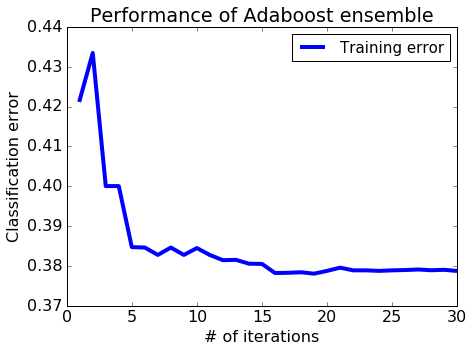

In [222]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

**Quiz Question**: Which of the following best describes a **general trend in accuracy** as we add more and more components? Answer based on the 30 components learned so far.

1. Training error goes down monotonically, i.e. the training error reduces with each iteration but never increases.
2. Training error goes down in general, with some ups and downs in the middle.
3. Training error goes up in general, with some ups and downs in the middle.
4. Training error goes down in the beginning, achieves the best error, and then goes up sharply.
5. None of the above


### Evaluation on the test data

**25.** Performing well on the training data is cheating, so lets make sure it works on the `test_data` as well. Here, we will compute the classification error on the `test_data` at the end of each iteration.

For n = 1 to 30, do the following:

*    Make predictions on test_data using tree stumps 0, ..., n-1.
*    Compute classification error for the predictions
*    Record the classification error for that n.

In [223]:
test_error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = (predictions != test_data[target]).sum() / float(len(test_data))
    #error = 1.0 - graphlab.evaluation.accuracy(test_data[target], predictions)
    test_error_all.append(error)
    print "Iteration %s, test error = %s" % (n, test_error_all[n-1])

Iteration 1, test error = 0.42330891857
Iteration 2, test error = 0.428479103835
Iteration 3, test error = 0.398104265403
Iteration 4, test error = 0.398104265403
Iteration 5, test error = 0.379900904782
Iteration 6, test error = 0.380008616975
Iteration 7, test error = 0.379254631624
Iteration 8, test error = 0.380008616975
Iteration 9, test error = 0.379254631624
Iteration 10, test error = 0.379685480396
Iteration 11, test error = 0.379254631624
Iteration 12, test error = 0.377962085308
Iteration 13, test error = 0.379254631624
Iteration 14, test error = 0.377854373115
Iteration 15, test error = 0.378500646273
Iteration 16, test error = 0.377854373115
Iteration 17, test error = 0.377962085308
Iteration 18, test error = 0.377854373115
Iteration 19, test error = 0.378177509694
Iteration 20, test error = 0.376884963378
Iteration 21, test error = 0.377531236536
Iteration 22, test error = 0.376777251185
Iteration 23, test error = 0.376777251185
Iteration 24, test error = 0.376884963378
It

### Visualize both the training and test errors

Now, let us plot the training & test error with the number of iterations.

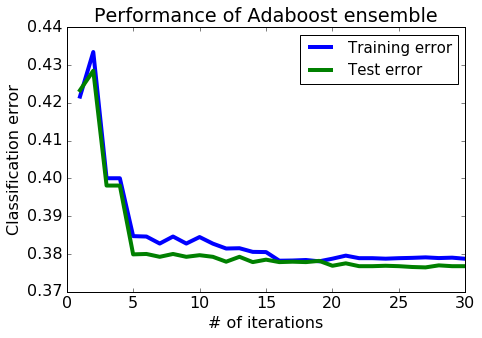

In [224]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()

** Quiz Question:** From this plot (with 30 trees), is there massive overfitting as the # of iterations increases?